# Preprocess CNAs from Firehose
In this notebook, I want to preprocess all the CNA data that Hotnet2 used for their identification of significant submodules. I already downloaded the the output from GISTIC2 from Firehose, using the firehose_get tool with:

`./firehose_get -tasks gistic analysis latest`

This was cumbersome and now I have one folder, containing gzipped folders for each cancer type.
The result are two matrices that are written to disk.

* The first matrix has shape $\big(genes \times cancertypes\big) \in \mathrm{R}$ and contains the mean number of samples for which the gene was affected.
* The second matrix $\big(genes \times samples\big) \in \{0, 1\}$ contains a $1$ if the gene in the sample is affected by a CNA and $0$ otherwise.

In [1]:
import pandas as pd
import numpy as np
import gzip
import os, sys
import tarfile

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## Parameters for the Script
The parameters have the following meaning:
* `GISTIC_THRESHOLD`: GISTIC2 writes for each sample if a CNA is affecting the gene with a high probability (2) and medium probability (1) or not (0). Setting the threshold to 1 means that you also use CNAs with medium probability. Setting it to 2 means that you use only high confidence CNAs.
* `ANALYSIS_DATE`: Firehose has multiple analyses done and they can be downloaded at different time points. Currently (April 2018), `latest` in the firehose_get command refers to 20160128.
* `ROOT_DIR`: The directory in which the firehose data can be found.
* `CANCER_TYPES`: The cancer types you are interested in as a list.

In [2]:
GISTIC_THRESHOLD = 1
ANALYSIS_DATE = '20160128' # latest
ROOT_DIR = '/home/sasse/bin/firehose/analyses__2016_01_28/' # where the firehose download is located
# CANCER_TYPES describes the cancer types, I am interested in
CANCER_TYPES = ['BLCA', 'BRCA', 'COADREAD', 'GBM', 'HNSC', 'KIRC', 'LAML', 'LUAD', 'LUSC', 'OV', 'UCEC']

In [3]:
def get_target_genes(fname):
    """Extract all genes per CNA from file
    
    This method extracts the target genes for all CNAs (either amps or dels) from GISTIC2 output files.
    Parameters:
    ---------
    fname:            The file to read from
    
    Returns:
    A dictionary with the descriptors of the CNAs as keys. The values are lists of target genes.
    """
    cna_genes_df = pd.read_csv(fname, sep='\t')
    relevant_cols = cna_genes_df.iloc[3:, 1:].dropna(how='all', axis=1)
    genes_per_cna = {}
    for col in relevant_cols.columns:
        genes_per_cna[col] = [i.split('|')[0] for i in relevant_cols[col].dropna().tolist()]
    return genes_per_cna

def get_genes_from_target_dict(genes_per_cna):
    return list(set({x for v in genes_per_cna.values() for x in v}))

def get_samples(lesions):
    return lesions.iloc[:, 9:].dropna(how='all', axis=1).columns


def get_target_genes_from_gistic(lesions, amps, dels):
    # first, get the target genes for all CNAs
    amp_targets = get_target_genes(amps)
    del_targets = get_target_genes(dels)
    all_targets = {**amp_targets, **del_targets} # no duplicate keys possible
    list_of_targets = get_genes_from_target_dict(all_targets)
    
    # Next, get the sample IDs
    all_lesions = pd.read_csv(lesions, sep='\t')
    samples = get_samples(all_lesions)
    
    # construct target matrix (genes x samples; 1 indicates that sample has CNA affecting the gene)
    target_gene_matrix = pd.DataFrame(0, index=list_of_targets, columns=samples)
    all_lesions = all_lesions[~all_lesions['Unique Name'].str.contains("CN values")]
    for sample in samples:
        cnas = all_lesions[all_lesions.loc[:, sample] >= GISTIC_THRESHOLD].Descriptor
        genes_subset = dict((k, all_targets[k.strip()]) for k in cnas)
        target_genes_for_sample = get_genes_from_target_dict(genes_subset)
        target_gene_matrix.loc[target_gene_matrix.index.isin(target_genes_for_sample), sample] = 1
    return target_gene_matrix
    

def get_target_genes_per_sample(root_dir, cancer_type, analysis_date):
    analysis_dir = 'gdac.broadinstitute.org_{}-T{}.CopyNumber_Gistic2.Level_4.{}00.0.0.tar.gz'
    p = os.path.join(root_dir, analysis_dir.format(cancer_type, 'B' if cancer_type is 'LAML' else 'P', analysis_date))
    if os.path.isfile(p):
        #print ("Extracting target genes from {}".format(p))
        dir_prefix = analysis_dir.rstrip(".tar.gz").format(cancer_type, 'B' if cancer_type is 'LAML' else 'P', analysis_date)
        tar = tarfile.open(p, "r:gz")
        lesions_tar = tar.extractfile(tar.getmember(os.path.join(dir_prefix, 'all_lesions.conf_99.txt')))
        amp_tar = tar.extractfile(tar.getmember(os.path.join(dir_prefix, 'amp_genes.conf_99.txt')))
        del_tar = tar.extractfile(tar.getmember(os.path.join(dir_prefix, 'del_genes.conf_99.txt')))
        return get_target_genes_from_gistic(lesions_tar, amp_tar, del_tar)
    else:
        print ("Error. Path {} does not exist".format(p))

def extract_targets_all_cancers(root_dir, analysis_date, cancer_types):
    result_samples = None
    result_cancertype = None
    for cancer_type in cancer_types:
        sample_matrix = get_target_genes_per_sample(os.path.join(root_dir, cancer_type, analysis_date),
                                                    cancer_type, analysis_date)
        mean_matrix = pd.DataFrame(sample_matrix.mean(axis=1), columns=[cancer_type])
        print ("For Cancer {}:".format(cancer_type))
        print ("Found {} genes for {} samples with avg {} mutated genes".format(sample_matrix.shape[0],
                                                                                sample_matrix.shape[1],
                                                                                sample_matrix.sum().sum() / sample_matrix.shape[1]))
        print ("{0:.2f}% mutations across all samples".format((sample_matrix.sum().sum() / np.prod(sample_matrix.shape))*100))
        print ("-----------------------------------------")
        if result_samples is None:
            result_samples = sample_matrix
            result_cancertype = mean_matrix
            
        else:
            result_samples = result_samples.append(sample_matrix)
            result_cancertype = result_cancertype.append(mean_matrix)
            
    result_samples.fillna(0, inplace=True)
    result_cancertype.fillna(0, inplace=True)
    result_samples = result_samples.groupby(result_samples.index).sum()
    result_cancertype = result_cancertype.groupby(result_cancertype.index).sum()
    return result_samples, result_cancertype

In [4]:
cna_sample_matrix, cna_mean_matrix = extract_targets_all_cancers(ROOT_DIR, ANALYSIS_DATE, CANCER_TYPES)

For Cancer BLCA:
Found 3687 genes for 408 samples with avg 1477.5931372549019 mutated genes
40.08% mutations across all samples
-----------------------------------------
For Cancer BRCA:
Found 2920 genes for 1080 samples with avg 937.887962962963 mutated genes
32.12% mutations across all samples
-----------------------------------------
For Cancer COADREAD:
Found 4812 genes for 616 samples with avg 1405.5974025974026 mutated genes
29.21% mutations across all samples
-----------------------------------------
For Cancer GBM:
Found 2618 genes for 577 samples with avg 570.0606585788562 mutated genes
21.77% mutations across all samples
-----------------------------------------
For Cancer HNSC:
Found 3566 genes for 522 samples with avg 860.8122605363984 mutated genes
24.14% mutations across all samples
-----------------------------------------
For Cancer KIRC:
Found 5524 genes for 528 samples with avg 1288.7121212121212 mutated genes
23.33% mutations across all samples
----------------------

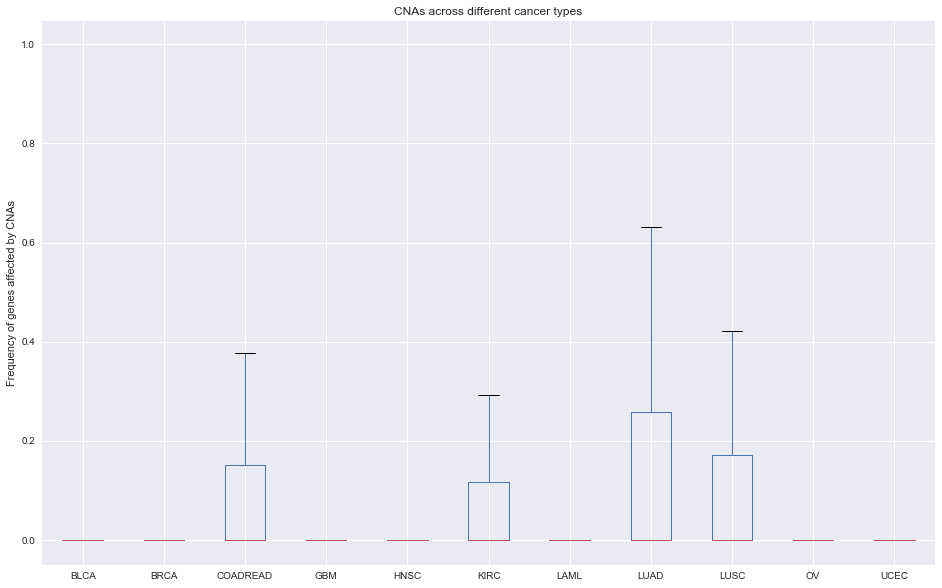

In [5]:
ax = cna_mean_matrix.plot(kind='box', figsize=(16, 10), title='CNAs across different cancer types')
ax.set_ylabel('Frequency of genes affected by CNAs')

In [7]:
cna_mean_matrix.to_csv('../data/cancer/TCGA/firehose_cnas_meancancertypes_{}.tsv'.format(ANALYSIS_DATE), sep='\t')
cna_sample_matrix_int = cna_sample_matrix.astype(np.uint8) # saves space and time
cna_sample_matrix_int.to_csv('../data/cancer/TCGA/firehose_cnas_sample_{}.tsv'.format(ANALYSIS_DATE), sep='\t')